In [3]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras import layers, losses

In [5]:
np.random.seed(1)

# Load MNIST dataset

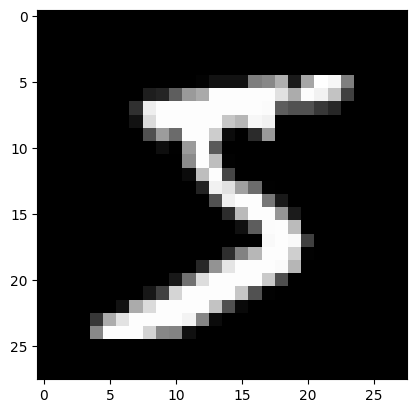

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

# Self supervised learning method

## Define autoencoder

In [7]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Create encoder

In [8]:
autoencoder_denoise = Denoise()

### Add noise

In [9]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Train Model

In [10]:
autoencoder_denoise.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder_denoise.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1138 - val_loss: 0.1140
Epoch 2/10
1875/1875 [==============================] - 50s 27ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
1875/1875 [==============================] - 42s 22ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
1875/1875 [==============================] - 49s 26ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
1875/1875 [==============================] - 46s 25m

## Classification

### Extract encoder

In [11]:

# Extract the encoder part for later use
pretrain_encoder = Denoise().encoder
pretrain_encoder.set_weights(autoencoder_denoise.encoder.get_weights())


# Add a classifier on top of the encoder
classification_model = tf.keras.Sequential([
    pretrain_encoder,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Train the classifier
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classification_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Evaluate on the test set
accuracy = classification_model.evaluate(x_test, y_test)[1]
print("Test Accuracy:", accuracy)



Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.5994 - accuracy: 0.8120 - val_loss: 0.1708 - val_accuracy: 0.9475
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2752 - accuracy: 0.9175 - val_loss: 0.1243 - val_accuracy: 0.9608
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2158 - accuracy: 0.9362 - val_loss: 0.1078 - val_accuracy: 0.9670
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1815 - accuracy: 0.9462 - val_loss: 0.0891 - val_accuracy: 0.9723
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1549 - accuracy: 0.9543 - val_loss: 0.0850 - val_accuracy: 0.9728
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1350 - accuracy: 0.9589 - val_loss: 0.0767 - val_accuracy: 0.9773
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1211 - accuracy: 0.9635 - val_loss: 0.0664 - val_accuracy